In [1]:
using AlfvenDetectors
using GenerativeModels
#using PyPlot
using Plots
using BSON
using Flux
using ValueHistories
using StatsBase
using Random

┌ Info: Recompiling stale cache file /home/vit/.julia/compiled/v1.1/AlfvenDetectors/VqnlF.ji for AlfvenDetectors [5e555b46-3391-11e9-1beb-e9498a8cd634]
└ @ Base loading.jl:1184
┌ Warning: Package GenerativeModels does not have BSON in its dependencies:
│ - If you have GenerativeModels checked out for development and have
│   added BSON as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GenerativeModels
└ Loading BSON into GenerativeModels from project dependency, future warnings for GenerativeModels are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for AlfvenDetectors [5e555b46-3391-11e9-1beb-e9498a8cd634]
│   exception = ErrorException("Required dependency GenerativeModels [316c64c6-6a49-11e9-07fe-e73d6c9df589] failed to load from a cache file.")
└ @ Base loading.jl:969
┌ Info: Recompiling stale cache file /home/vit/.julia/compiled/v

In [5]:
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [4]:
mf = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/ConvWAE_channels-[8,16]_patchsize-128_nepochs-1_2019-05-07T15:09:31.304.bson"
model_data = BSON.load(mf)
exp_args = model_data[:experiment_args]
model_args = model_data[:model_args]
model_kwargs = model_data[:model_kwargs]
history = model_data[:history]
model = Flux.testmode!(GenerativeModels.construct_model(mf));

In [6]:
# now get some data
datapath = "/home/vit/vyzkum/alfven/cdb_data/uprobe_data"
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
shotnos, labels, tstarts, fstarts = AlfvenDetectors.labeled_patches()
patchdata = map(x->AlfvenDetectors.get_patch(datapath,x[1], x[2], x[3], patchsize, readfun;
	memorysafe = true)[1],	zip(shotnos, tstarts, fstarts))
data = cat(patchdata..., dims=4)


128×128×1×371 Array{Float32,4}:
[:, :, 1, 1] =
 0.2688    0.31648   0.330007  0.325868  …  0.365905   0.327201   0.247084
 0.287049  0.303855  0.245171  0.378957     0.313237   0.315635   0.230885
 0.326752  0.314801  0.320711  0.36616      0.293126   0.30671    0.27764 
 0.358278  0.16063   0.167523  0.318327     0.205949   0.151177   0.320106
 0.360888  0.296483  0.23007   0.241276     0.304698   0.305032   0.356173
 0.33037   0.246519  0.318273  0.344417  …  0.36442    0.35915    0.261176
 0.271752  0.290667  0.316469  0.365946     0.360922   0.346863   0.206875
 0.341084  0.341373  0.267604  0.332758     0.393081   0.373271   0.219149
 0.40413   0.392199  0.344802  0.271197     0.374226   0.384604   0.370754
 0.370826  0.283903  0.325662  0.345013     0.311568   0.279604   0.349777
 0.389296  0.356125  0.344813  0.247057  …  0.33649    0.36875    0.294697
 0.346345  0.28334   0.373488  0.385175     0.384576   0.364443   0.380344
 0.314783  0.29271   0.380813  0.377011     0.208919 

In [9]:
Z = model.encoder(data).data;
gZ = model.pz(400);

In [22]:
using Plots
gr()

Plots.GRBackend()

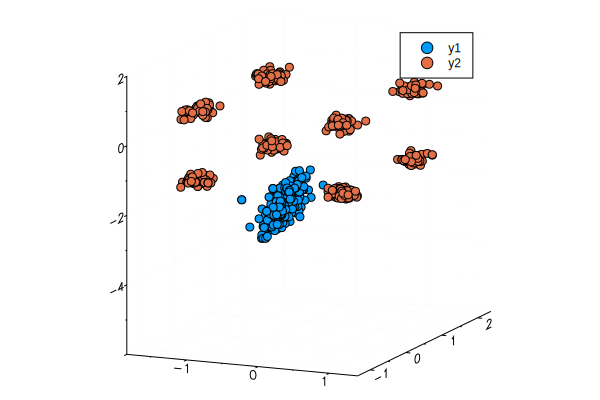

In [27]:
Plots.scatter(Z[1,:], Z[2,:], Z[3,:])
Plots.scatter!(gZ[1,:], gZ[2,:], gZ[3,:])

In [ ]:
modelpath = "/home/vit/vyzkum/alfven/experiments/conv_old_library/uprobe/"

In [ ]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/uprobe_data/"
labeled_shots, shot_labels = AlfvenDetectors.labeled_data()
Random.seed!(123)
iused = sample(1:size(labeled_shots,1), 10, replace=false)
labeled_shots = labeled_shots[iused]
shot_labels = shot_labels[iused]
datafiles = readdir(datapath);
println("$(length(datafiles)) shots available")

In [ ]:
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
data_labels = []
data_shotnos = []
data = Array{Float32,4}(undef,patchsize,patchsize,1,0)
for (label, shot) in zip(shot_labels, labeled_shots)
    file = joinpath.(datapath, datafiles[map(x->occursin("$shot", x),datafiles)])
    X = AlfvenDetectors.collect_conv_signals(file, readfun, patchsize)
    N = size(X,4)
    data = cat(data,X,dims=4)
    push!(data_labels, fill(label,N))
    push!(data_shotnos, fill(shot,N))
end
data_labels = vcat(data_labels...);
data_shotnos = vcat(data_shotnos...);

In [ ]:
testdata = readfun(joinpath(datapath, "uprobe_10893.h5"));
testdata = testdata[129:384, 1537:2816]
figure()
pcolormesh(testdata)
testdata = AlfvenDetectors.split_reshape(testdata,patchsize);
size(testdata)

In [ ]:
mf = joinpath(modelpath, "batchnorm-test/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-05T17:03:35.079.bson")
# this is the best model, however it was trained on the 10893 data
#mf = joinpath(modelpath, "outbatchnorm/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-false_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T22:20:35.763.bson")
#mf = joinpath(modelpath, "outbatchnorm/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-true_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T20:12:06.821.bson")
model_data = BSON.load(mf)
params = parse_params(mf)
hist = model_data[:history]
model = model_data[:model]
if get(params, :batchnorm, false)
    Flux.testmode!(model);
end
display(params)
is,ls = get(hist,:loss)
vl = AlfvenDetectors.loss(model, testdata).data
println("trainig loss: $(ls[end])")
println("validation loss: $vl")

Check the reconstructions.

In [ ]:
cmap="plasma"
for i in 1:size(testdata,4)
    figure(figsize=(10,5))
    subplot(1,2,1)
    pcolormesh(testdata[:,:,1,i], cmap=cmap)
    subplot(1,2,2)
    pcolormesh(model(testdata[:,:,:,i:i]).data[:,:,1,1], cmap=cmap)
    
end

In [ ]:
testdata

In [ ]:
GC.gc()

In [ ]:
# now compute the code in batches
batchsize = 10
z = model.encoder(data[:,:,:,1:batchsize]).data;
for i in 2:floor(Int,size(data,4)/batchsize)
    z=cat(z, model.encoder(data[:,:,:,((i-1)*batchsize+1):i*batchsize]).data, dims=2)
end
z=cat(z, model.encoder(data[:,:,:,end-(size(data,4)%batchsize)+1:end]).data, dims=2);

In [ ]:
plt.hist(mean(z,dims=2))

In [ ]:
umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)

In [ ]:
z2D = Array(umap_model.fit_transform(z')')

In [ ]:
scatter(z2D[1,:],z2D[2,:],s=5)
title("data from shots $(labeled_shots)")

In [ ]:
for shotno in unique(data_shotnos)
    zs = z2D[:,data_shotnos.==shotno]
    scatter(zs[1,:], zs[2,:],s=5,label="$shotno")
end
legend()

In [ ]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
legend()

In [ ]:
testz = model.encoder(testdata).data;
testz2D = Array(umap_model.transform(testz')')

In [ ]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")
legend()

In [ ]:
clusterinds = collect(1:size(z2D,2))[ (-50. .< z2D[1,:] .< -10) .&  (-10 .< z2D[2,:] .< 10)]
#clusterinds = collect(1:size(z2D,2))[ (-2. .< z2D[1,:] .< 1) .&  (0 .< z2D[2,:] .< 3)]
#clusterinds = collect(1:size(z2D,2))[ (0.5 .< z2D[1,:] .< 3) .&  (5.5 .< z2D[2,:] .< 6.5)]
scatter(z2D[1,clusterinds],z2D[2,clusterinds])
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")


In [ ]:
for i in clusterinds
    figure()
    pcolormesh(data[:,:,1,i], cmap="plasma")
    title("$i, label = $(data_labels[i])")
end

In [ ]:
plt.hist(mean(z,dims=2))

In [ ]:
plt.hist(mean(z[:,clusterinds],dims=2))